<a id="top"></a>

## Table of Contents
1. [Setup & Data Load](#setup)
2. [Data Quality Checks](#dq)
3. [1990s Subset](#subset)
4. [Q1 — What was the most frequent movie duration in the 1990s?](#q1)
5. [Q2 — How many short Action movies (< 90 min) were released in the 1990s?](#q2)
6. [Q3 — Which year(s) in the 1990s had the most movie releases?](#q3)
7. [Q4 — Which genres dominated the 1990s?](#q4)
8. [Q5 — Where are the content gaps we could fill?](#q5)
9. [Findings & Next Steps](#findings)
10. [Appendix — Alternative Approaches and Plots](#appendix)

# Netflix 1990s Movies – Exploratory Case Study
**Author:** Andreza Eufrasio

**Objective:**: A compact portfolio-ready analysis answering five practical questions about Netflix movies in the 1990s. Each question includes *why it matters*, *method*, and *result*.


<center><img src="redpopcorn.jpg"></center>

## Business Context

Netflix’s content team wants to understand **what worked in the 1990s** to support catalog curation and nostalgic promotions. 

**Key questions:**

1) What runtime trends dominated 1990s movies?  
2) How prevalent is **short-form** (<90 min) content, especially in **Action**?  
3) Which **years** were most prolific?  
4) Which **genres** dominated the decade?  
5) Where are the **content gaps** we could fill?  

## Deliverables
- Clear answers to the questions above, with **visualizations.**
- **Actionable recommendations** for stakeholders based on findings.
- Clean, **reproducible notebook** following best practices.

### Dataset: 


| Column | Description |
|--------|-------------|
| `show_id` | The ID of the show |
| `type` | Type of show |
| `title` | Title of the show |
| `director` | Director of the show |
| `cast` | Cast of the show |
| `country` | Country of origin |
| `date_added` | Date added to Netflix |
| `release_year` | Year of Netflix release |
| `duration` | Duration of the show in minutes |
| `description` | Description of the show |
| `genre` | Show genre |

We use a Netflix dataset and narrow it to the 1990s, focusing on the fields most relevant to content analysis: **type**,
**genre**, **duration**, **release_year**.

These variables directly support the business questions.

In [9]:
!python --version

Python 3.12.7


<h2 id="setup">1) Setup & Data Load</h2

In [12]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Expect a file named 'netflix_data.csv' in the same folder.
netflix_df = pd.read_csv("netflix_data.csv")

# Normalize Column Names

In [15]:
# Normalize column names (common variants across Netflix datasets)

netflix_df.columns = (netflix_df.columns
                      .str.strip().str.lower()
                      .str.replace(r"[ /\-\(\)]+", "_", regex =True)
                      .str.replace(r"_+", "_", regex=True)
                      .str.strip("_")
                     )
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,duration,description,genre
0,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,93,After a devastating earthquake hits Mexico Cit...,Dramas
1,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,78,"When an army recruit is found dead, his fellow...",Horror Movies
2,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,80,"In a postapocalyptic world, rag-doll robots hi...",Action
3,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,123,A brilliant group of students become card-coun...,Dramas
4,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",2016,1,A genetics professor experiments with a treatm...,International TV


<h2 id="dq">2) Data Quality Checks</h2>

# Basic Info (rows, columns)

In [19]:
# Basic info

print(f" Rows: {netflix_df.shape[0]}  and Columns: {netflix_df.shape[1]}","\n" )

# check the original NaNs
netflix_df.info()

 Rows: 4812  and Columns: 11 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       4812 non-null   object
 1   type          4812 non-null   object
 2   title         4812 non-null   object
 3   director      4812 non-null   object
 4   cast          4812 non-null   object
 5   country       4812 non-null   object
 6   date_added    4812 non-null   object
 7   release_year  4812 non-null   int64 
 8   duration      4812 non-null   int64 
 9   description   4812 non-null   object
 10  genre         4812 non-null   object
dtypes: int64(2), object(9)
memory usage: 413.7+ KB


# NA Check Function 
# Coerce to Numeric: release_year, duration
  * Any stray non-numeric values in release_year/duration are coerced to NaN.
# Validate — NaN Counts After Coercion


In [22]:
# Define function first
def check_and_count_na(series):
    na_count = series.isna().sum()
    if na_count == 0:
        print("0 (no NaN values)")
    else:
        print(f"1 (has NaN values) — Total NaNs: {na_count}")

# Convert columns afterwards
num_cols = ['release_year', 'duration']
netflix_df[num_cols] = netflix_df[num_cols].apply(pd.to_numeric, errors='coerce')


# Then run function to check both original NaNs and any invalid strings that were coerced into NaN
check_and_count_na(netflix_df['release_year'])
check_and_count_na(netflix_df['duration'])


0 (no NaN values)
0 (no NaN values)


# Detect Placeholder Values in Categorical Columns

In [25]:
# Detect & Count Bad Placeholders in Categorical Columns
bad_values = ["?", "N/A", "NA", "n/a", "Unknown", "unknown", "None", "", " ", "-", "--"]

for col in netflix_df.select_dtypes(include=['object', 'string', 'category']).columns:
    bad_count = netflix_df[col].isin(bad_values).sum()
    if bad_count > 0:
        print(f"Column '{col}' has {bad_count} bad values","\n")
    else:
        print(f"Column '{col}' has zero bad values","\n")


Column 'show_id' has zero bad values 

Column 'type' has zero bad values 

Column 'title' has 1 bad values 

Column 'director' has zero bad values 

Column 'cast' has zero bad values 

Column 'country' has zero bad values 

Column 'date_added' has zero bad values 

Column 'description' has zero bad values 

Column 'genre' has zero bad values 



In [27]:
# bad_values already defined above
mask_bad_title = netflix_df['title'].isin(bad_values)

# preview the bad row(s)
netflix_df.loc[mask_bad_title, ['show_id','type','title', 'duration', 'genre']]


,show_id,type,title,duration,genre
4562,s7352,Movie,Unknown,113,Action


# Drop Rows with Bad title

In [30]:
# drop and reindex
netflix_df = netflix_df.loc[~mask_bad_title].reset_index(drop=True)

# sanity check
print("Remaining bad titles:", netflix_df['title'].isin(bad_values).sum())

Remaining bad titles: 0


# Duplicate Checks (exact & logical keys)

In [32]:
# Duplicates (exact row + logical keys)
print("Exact duplicate rows:", netflix_df.duplicated().sum(),"\n")

dups_keys = netflix_df.duplicated(subset=["title", "genre", "release_year","duration", "type"]).sum()
print("Duplicates on title + genre + year + duration + type:", dups_keys)

Exact duplicate rows: 0 

Duplicates on title + genre + year + duration + type: 0


# Numeric Summary (min/max)

In [38]:
# Range checks 
print("Year range:", int(netflix_df["release_year"].min()), "→", int(netflix_df["release_year"].max()),"\n")
print("Duration range:", int(netflix_df["duration"].min()), "→", int(netflix_df["duration"].max()))

Year range: 1942 → 2021 

Duration range: 1 → 253


# Plots (Year & Duration Distributions)
* Release years are concentrated post-2010; durations cluster around ~90–110 minutes.

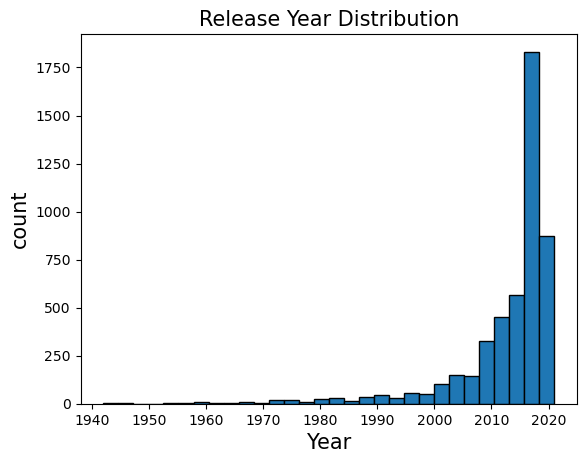

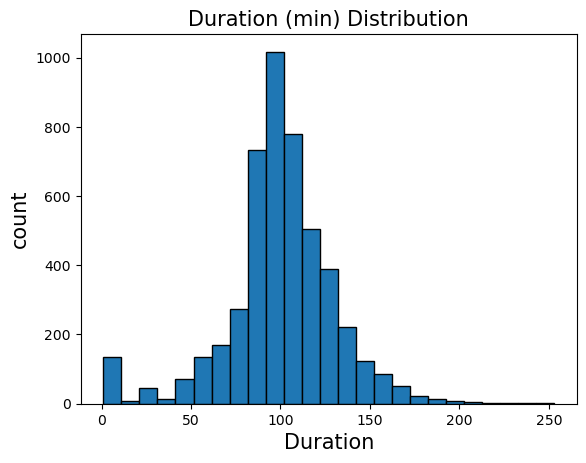

In [45]:
# One-line visuals for sanity
plt.figure()
netflix_df["release_year"].plot(kind="hist", bins=30, edgecolor ='black') 
plt.title("Release Year Distribution", fontsize =15)
plt.xlabel('Year', fontsize =15)
plt.ylabel('count', fontsize =15)
plt.show()

print()
plt.figure()
netflix_df["duration"].plot(kind="hist", bins=25, edgecolor ='black') 
plt.title("Duration (min) Distribution", fontsize =15)
plt.xlabel('Duration', fontsize =15)
plt.ylabel('count', fontsize =15)
plt.show()

# Memory Footprint

In [48]:
# Memory footprint (shows you thought about efficiency)
print("Approx. memory:", round(netflix_df.memory_usage(deep=True).sum()/1e6, 2), "MB")

Approx. memory: 4.17 MB


<h2 id="subset">3) 1990s Subset</h2>

We subset the catalog to **Movies** released from **1990–1999.** 

In [52]:
movies_90_df = netflix_df[
                                (netflix_df["type"] == "Movie") & 
                                (netflix_df['release_year'] >= 1990) & 
                                (netflix_df['release_year'] < 2000)
                                 ].copy()
movies_90_df.shape

(183, 11)

In [56]:
# Basic checks
print(movies_90_df["type"].value_counts().head(),"\n")

print(movies_90_df['release_year'].value_counts().sort_index())

type
Movie    183
Name: count, dtype: int64 

release_year
1990    14
1991    14
1992    16
1993    16
1994    14
1995    16
1996    15
1997    26
1998    26
1999    26
Name: count, dtype: int64


<h2 id="q1">4) Q1 — What was the most frequent movie duration in the 1990s?</h2>

**Why it matters:** Understanding the most common runtime informs recommendation defaults, editorial curation, and trailer cuts.

**Method:** Use `Series.mode()` on `duration`.

**Result & Visual:**

In [65]:
# Q1 - What was the most frequent movie duration in the 1990s?

duration = movies_90_df["duration"].mode()[0]

print(f" The most frequent movie duration in the 1990s is {duration} ")

 The most frequent movie duration in the 1990s is 94 


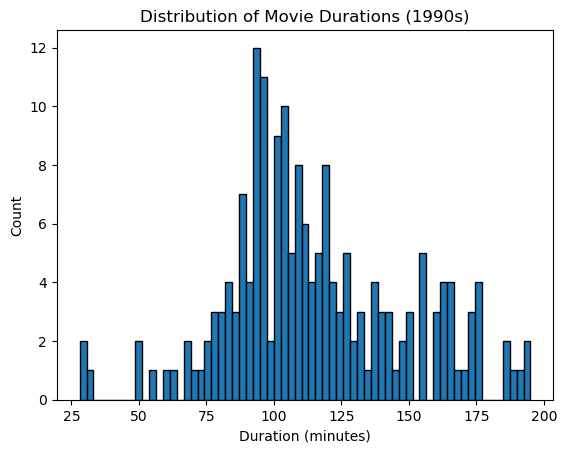

In [69]:
# Distribution of durations (1990s)
plt.figure()
movies_90_df["duration"].plot(kind="hist", bins=65, edgecolor="black")
plt.title("Distribution of Movie Durations (1990s)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.show()

## Insights

* Using the **mode** of the `duration` column, the most frequent runtime of 1990s movies was found to be **94 minutes**.
* This indicates that filmmakers in the 1990s often aimed for runtimes around **1 hour 30 minutes to 1 hour 40 minutes**, which is considered a “standard” feature length.
* The clustering of runtimes around this length reflects a balance between storytelling depth and audience attention span.


## Recommendations

* **Recommendation Defaults**: Use \~94 minutes as a baseline when recommending similar films, since it represents the “typical” runtime of the decade.
* **Editorial Curation**: Create curated lists like *“Classic 90-Minute 90s Films”* for viewers looking for average-length, easy-to-consume movies.
* **Trailer Cuts and Summaries**: Editors can focus marketing efforts around this runtime, since it was the industry norm.


## Final Answer

The most frequent movie duration in the 1990s was **94 minutes**.


<h2 id="q2">5) Q2 — How many short Action movies (< 90 min) were released in the 1990s?</h2>

**Why it matters:** Short-form Action content can be promoted for “quick watch” campaigns and mobile-first audiences.

**Method:** Boolean filter by `genre == 'Action'` and `duration < 90`.

**Result:**

In [76]:
#Q2 - How many is short-Action movies (<90 min) were released in the 1990s?
short_movie_count = movies_90_df[
                                  (movies_90_df["genre"] == "Action") &
                                  (movies_90_df["duration"] < 90)].shape[0]

print(f" The number of short action movies released in the 1990s is {short_movie_count}")

 The number of short action movies released in the 1990s is 7


In [78]:
# Share of all 1990s movies that are short Action.
pct_of_all = round(short_movie_count / len(movies_90_df) * 100, 1)

# how many action movies exist in the 1990s subset.
action_total = movies_90_df['genre'].eq('Action').sum()  

# Among Action movies, what percent are short.
pct_within_action = round(short_movie_count / action_total * 100, 1) if action_total else 0
print(f"{pct_of_all}% of all 1990s movies; {pct_within_action}% within Action.")


3.8% of all 1990s movies; 14.6% within Action.


**Insights**

* There are **7** short-Action movies in the 1990s subset.
* That’s \~**3.8%** of all 1990s movies (7 / 183). 
* This scarcity suggests the catalog skews toward **standard-length** Action (≈90–120 min), making short-Action a niche.

**Recommendations**

* **Quick-Watch Row:** Create a “<90-min Action” carousel for time-constrained viewers.
* **Acquisition Gap:** Consider licensing/commissioning more short-Action to strengthen this niche.
* **Mobile Campaigns:** Use short-Action in mobile/homepage promos where completion likelihood is higher.

**Final Answer**
The number of short-Action movies (< 90 min) released in the 1990s is **7**.


<h2 id="q3">6) Q3 — Which year(s) in the 1990s had the most movie releases?</h2>

**Why it matters:** Peak years can power throwback rows or anniversary campaigns.

**Method:** `mode()` by `release_year`.

**Result & Visual:**

In [86]:
year_counts = movies_90_df["release_year"].value_counts().sort_index()
print(year_counts)
#print(type(year_counts))

release_year
1990    14
1991    14
1992    16
1993    16
1994    14
1995    16
1996    15
1997    26
1998    26
1999    26
Name: count, dtype: int64


In [88]:
peak_year = movies_90_df["release_year"].mode().tolist
print(f" {peak_year} is year in the 1990s has most movie released")
#print(type(peak_year))

 <bound method IndexOpsMixin.tolist of 0    1997
1    1998
2    1999
Name: release_year, dtype: int64> is year in the 1990s has most movie released


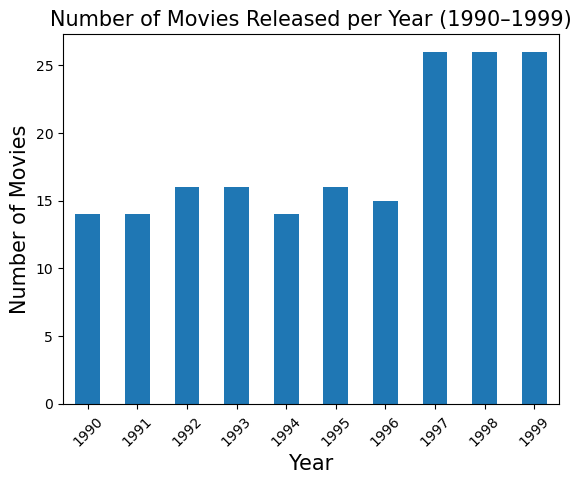

In [90]:
plt.figure()
year_counts.plot(kind='bar')
plt.title('Number of Movies Released per Year (1990–1999)', fontsize =15)
plt.xlabel('Year', fontsize =15)
plt.ylabel('Number of Movies', fontsize =15)
plt.xticks(rotation=45)
plt.show()

## Insights

* The dataset shows that the early 1990s (1990–1996) had a steady but modest release volume of **14–16 movies per year**.
* From **1997 onward, there was a sharp increase**, with **1997, 1998, and 1999 each releasing 26 films** — almost double compared to the start of the decade.
* This indicates that the **late 1990s were the most prolific period** for movie releases in the decade.



## Recommendations


* **Anniversary Campaigns**: Highlight movies from 1997–1999 (e.g., “25 Years of 1999 Classics”) for nostalgic promotions.
* **Content Prioritization**: Streaming platforms should emphasize late ’90s titles since they represent the **largest portion of 1990s releases**.
* **Licensing Strategy**: Focus acquisition on late ’90s films to maximize catalog size and audience recognition.



## Final Answer

The **years 1997, 1998, and 1999 each had the most movie releases in the 1990s, with 26 films each**, making the **late 1990s the peak period for film output in the decade**.

<h2 id="q4">7) Q4 — Which genres dominated the 1990s?</h2>

**Why it matters:** Helps prioritize homepage rows and licensing focus.

**Method:** value_counts() on genre.

**Result & Visual:**

In [95]:
top_genre = movies_90_df["genre"].value_counts().sort_values(ascending = False)
top_genre

genre
Action            48
Dramas            44
Comedies          40
Children          15
Classic Movies    15
Stand-Up           8
Thrillers          5
Horror Movies      4
Documentaries      2
Cult Movies        2
Name: count, dtype: int64

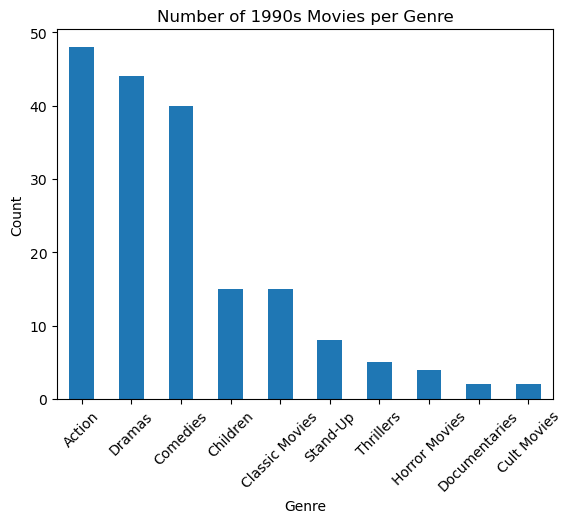

In [97]:
# Top genres (bar chart)
plt.figure()
top_genre.plot(kind ='bar')
plt.title("Number of 1990s Movies per Genre")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Insights

* The top three genres were **Action (48 movies)**, **Drama (44 movies)**, and **Comedy (40 movies)**.
* These three categories together account for the **majority of movie releases**, showing they were the dominant storytelling formats of the decade.
* Secondary genres such as **Children (15)**, **Classic Movies (15)**, and **Stand-Up (8)** were present but significantly less common.
* Niche genres like **Thrillers (5)**, **Horror (4)**, **Documentaries (2)**, and **Cult Movies (2)** had minimal representation, suggesting they were less central to 1990s mainstream output.


## Recommendations

* **Content Prioritization**: Platforms should promote Action, Drama, and Comedy as **the core 1990s genres**, reflecting audience preferences of that era.
* **Niche Targeting**: Smaller genres like Thrillers and Horror can be leveraged for **specialized marketing campaigns** or **curated collections** to appeal to specific audience segments.
* **Licensing Focus**: Ensure strong representation of the top three genres in catalogs, while selectively acquiring unique titles from niche genres to differentiate the offering.


## Final Answer

The **1990s were dominated by Action (48 movies), Drama (44 movies), and Comedy (40 movies)**, making them the defining genres of the decade.


<h2 id="q5">8) Q5 — Where are the content gaps we could fill?</h2>

We define "gap" as genres with **fewer than the median** number of 1990s movies.

**Why it matters:** Gaps highlights opportunities  to enrich the catalog.

**Method:** groupby('genre').size() to count 1990s movies per genre. Compare each genre’s count to the median (and show the mean as a reference). Define a gap as genres below the median presence.

**Result & Visual:**

In [102]:
# Count titles per genre
genre_counts = (
    movies_90_df
      .groupby('genre')  # group rows by the 'genre' value
      .size()                          # count rows in each group
      .sort_values(ascending=False)    # optional: show biggest first
      .rename('count')                 # nicer column name when displayed
)

genre_counts.head(10)

genre
Action            48
Dramas            44
Comedies          40
Children          15
Classic Movies    15
Stand-Up           8
Thrillers          5
Horror Movies      4
Cult Movies        2
Documentaries      2
Name: count, dtype: int64

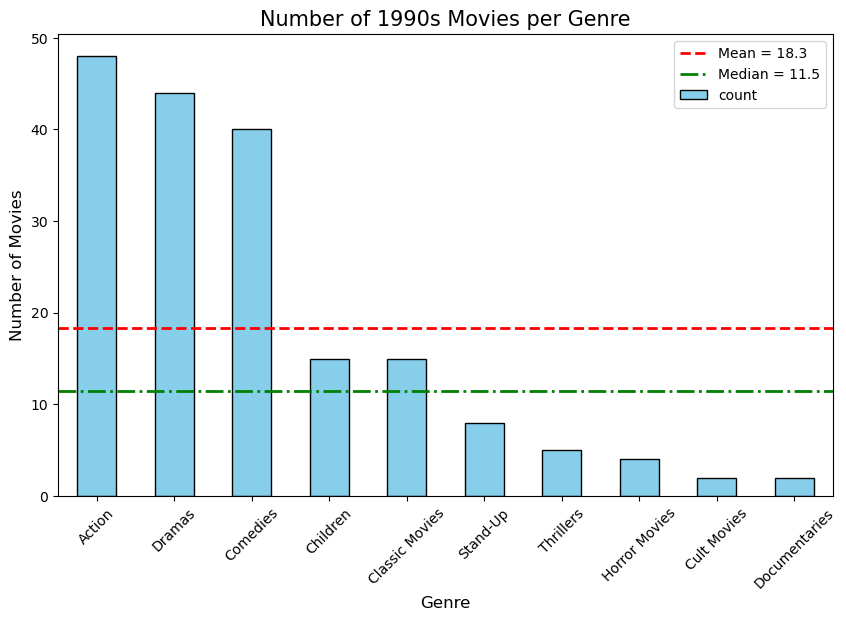

In [104]:
# Calculate mean and median
mean_count = genre_counts.mean()
median_count = genre_counts.median()

plt.figure(figsize=(10,6))
genre_counts.plot(kind="bar", color="skyblue", edgecolor="black")

# Add horizontal lines for mean and median
plt.axhline(mean_count, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_count:.1f}")
plt.axhline(median_count, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_count:.1f}")

# Add labels and title
plt.title("Number of 1990s Movies per Genre", fontsize=15)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.legend()

plt.xticks(rotation=45)
plt.show()


In [106]:
# Q5 — Where are the content gaps?
# Define "gaps" as genres with below-median representation within 1990s movies.

# Count movies per genre
genre_counts_full = movies_90_df['genre'].value_counts()

# Find the median number of movies across genres
if len(genre_counts_full) > 0:
    median_count = int(genre_counts_full.median())
else:
    median_count = 0

# Select genres with fewer movies than the median (content gaps)
content_gaps = genre_counts_full[genre_counts_full < median_count]

print("Median count:", median_count,'\n')
print("Content gaps:\n", content_gaps)


Median count: 11 

Content gaps:
 genre
Stand-Up         8
Thrillers        5
Horror Movies    4
Documentaries    2
Cult Movies      2
Name: count, dtype: int64


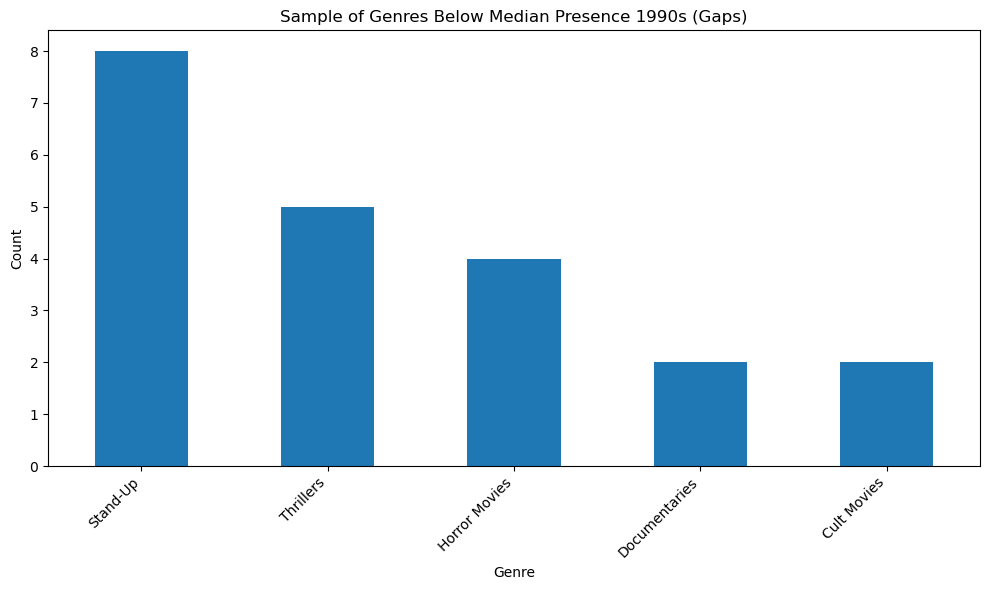

In [108]:
plt.figure(figsize=(10,6))
content_gaps.plot(kind = 'bar') 
plt.title('Sample of Genres Below Median Presence 1990s (Gaps)')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Insights**

* The bar chart shows a skewed distribution; **right-skewed**: mean > median, driven by a few dominant genres. A few genres (Drama/Action/Comedies) sit well above the mean (\~18), while a long tail of genres falls below the median (\~11.5) (green/red guides on the chart). The second plot highlights the largest below-median genres (the gaps).
* Most genres are **below the median threshold**, indicating under-represented themes in the 1990s catalog.
* The **top 3 genres** (leftmost bars) concentrate a large share of titles; the **long tail** represents clear diversification opportunities.
* Gaps are the genres **to the right of the median line** in the first chart and explicitly listed in your “Below-Median” plot (those are the primary candidates).

**Recommendations**

* **Acquisition/Production:** Prioritize the below-median genres featured in the second chart (top gaps first). Test 1–2 low-risk titles per gap to validate demand.
* **Audience Fit:** Cross-tab the gaps by **country** and **duration** to find the most viable intersections (e.g., short-form in a gap genre for mobile audiences).

**Final Answer**
Content gaps in the 1990s catalog are the **genres with counts below the median (~ 11–12)**. Focus first on the **largest below-median genres** highlighted in your “Sample of Genres Below Median Presence (Gaps)” chart; these represent the most promising opportunities to expand and diversify the catalog.


<h2 id="findings">9) Findings & Next Steps</h2>

Business-facing summary based on the analyses above.

### Summary of Insights
- **Most common runtime (mode):** Reported above; indicates the typical length of 1990s movies in our catalog.
- **Short Action availability:** `short_movie_count` shows if quick-watch Action content is scarce or healthy.
- **Peak release year:** `peak_year` with the highest count suggests a strong cohort for anniversary campaigns.
- **Genre concentration:** `top_genres` reveal dominant categories; `content_gaps` shows underrepresented areas.

### Recommendations for Stakeholders
1. **Recommendation engine tuning:** Prioritize titles near the **most frequent runtime** in “Because you watched 90s classics” rows.
2. **Quick‑watch Action row:** If `short_movie_count` is modest, consider **licensing** or **promoting** sub‑90‑minute Action films to serve mobile/light‑time users.
3. **Anniversary marketing:** Create seasonal collections around **`peak_year`** (e.g., “Best of 1997”).
4. **Genre curation:** Feature **top 3 genres** from the 1990s on homepage carousels for nostalgia‑driven traffic.
5. **Fill gaps:** Explore licensing in **underrepresented genres** (from `content_gaps`) to broaden appeal and long‑tail engagement.

<h2 id="appendix">10) Appendix — Alternative Approaches and Plots</h2>

# Q1 Alternatives

In [116]:
# Alternative for Q1 — value_counts().idxmax()

alt_duration = movies_90_df["duration"].value_counts().idxmax()
print(f"Most frequent duration via value_counts().idxmax(): {alt_duration} minutes")

Most frequent duration via value_counts().idxmax(): 94 minutes


In [118]:
m1 = movies_90_df['duration'].mode()
m2 = movies_90_df['duration'].value_counts().idxmax()
assert m1.size == 1 and int(m1[0]) == int(m2), f"Mismatch: mode={m1.tolist()} vs idxmax={m2}"
print(f"OK — single mode {int(m1[0])} matches idxmax {int(m2)}")


OK — single mode 94 matches idxmax 94


# Appendix A1 — Exact Runtime Counts (1990s)

## Counts of titles at each exact runtime (in minutes). Confirms the mode at 94 min and the clustering around ~90–110 min.

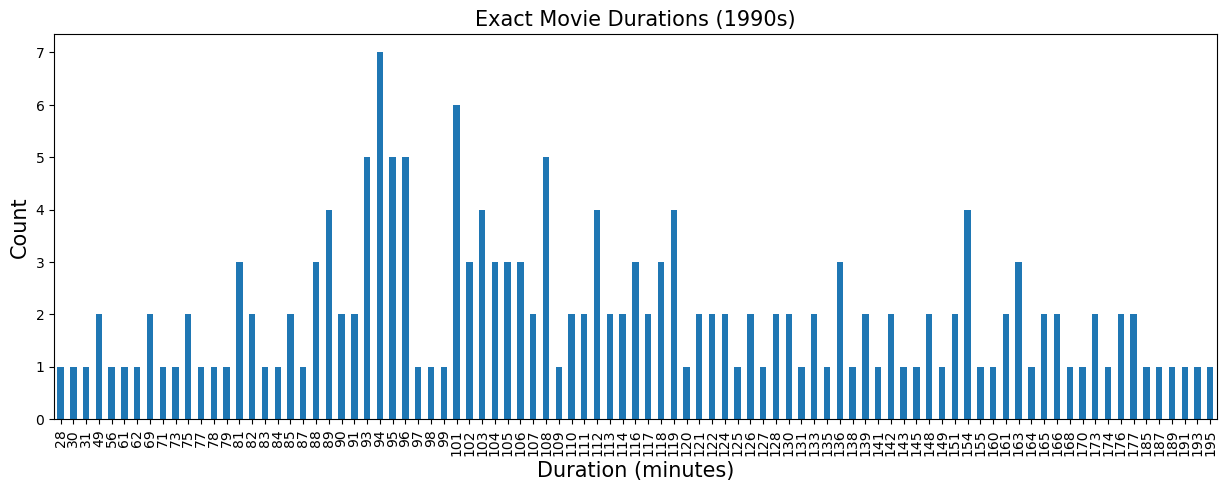

In [121]:
plt.figure()
movies_90_df['duration'].value_counts().sort_index().plot(kind='bar', figsize=(15,5))
plt.title("Exact Movie Durations (1990s)", fontsize = 15)
plt.xlabel("Duration (minutes)", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.tick_params(axis='x', labelrotation=90)
plt.show()

# Q2 Alternatives

In [124]:
# Alternative for Q2 — len()

short_movies = len(movies_90_df[
                              (movies_90_df["genre"] == "Action") &
                              (movies_90_df["duration"] < 90)
])
print(f" The number of short action movies released in the 1990s is {short_movies}")

 The number of short action movies released in the 1990s is 7


In [126]:
# Alternative for Q2 — Filter short action movies using NumPy logical_and

short_movie = movies_90_df[np.logical_and(movies_90_df["genre"] == "Action", movies_90_df["duration"] < 90)]
short_movie
#print(type(short_movie))

short_movie_count = len(short_movie)
                        
print(f" The number of short action movies released in the 1990s is {short_movie_count}")

 The number of short action movies released in the 1990s is 7


# Q3 Alternatives

In [129]:
# Alternative for Q3 

counts = movies_90_df['release_year'].value_counts().sort_index()
max_count = counts.max()
peak_years = counts[counts == max_count].index.tolist()

if len(peak_years) == 1:
    print(f"{peak_years[0]} had the most releases ({max_count}).")
else:
    years_str = ", ".join(map(str, peak_years))
    print(f"{years_str} tied for most releases ({max_count} each).")


1997, 1998, 1999 tied for most releases (26 each).


[Back to top](#top)
